# <center> Shearlab Introduction </center>

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Wavelets

### 2D Daubechies Wavelets

### Wavelets Filters

The 2-D wavelet transform of a continuous image $f(x)$ computes the set
of inner products 
$$ d_j^k[n] = \langle f,\psi_{j,n}^k\rangle $$ 
for scales $ j \in \mathbb{Z} $, position $ n \in \mathbb{Z}^2 $ and orientation $ k \in \{H,V,D\} $.


The wavelet atoms are defined by scaling and translating three mother
atoms $ \{\psi^H,\psi^V,\psi^D\} $:
$$ \psi_{j,n}^k(x) = \frac{1}{2^j}\psi^k \left( \frac{x-2^j n}{2^j} \right)  $$
These oriented wavelets are defined by a tensor product of a 1-D wavelet
function $\psi(t)$ and a 1-D scaling function $\phi(t)$
$$ \psi^H(x)=\phi(x_1)\psi(x_2), \quad \psi^V(x)=\psi(x_1)\phi(x_2)
\quad \psi^D(x)=\psi(x_1)\psi(x_2).$$


The fast wavelet transform algorithm does not make use of the wavelet and scaling functions,
but of the filters $h$ and $g$ that caracterize their interaction:
$$ g[n] = \frac{1}{\sqrt{2}}\langle \psi(t/2),\phi(t-n)\rangle 
\quad h[n] = \frac{1}{\sqrt{2}}\langle\phi(t/2),\phi(t-n)\rangle. $$


The simplest filters are the Haar filters
$$ h = [1, 1]/\sqrt{2} \quad g = [-1, 1]/\sqrt{2}. $$

Daubechies wavelets extends the haar wavelets by using longer
filters, that produce smoother scaling functions and wavelets.
Furthermore, the larger the size $p=2k$ of the filter, the higher is the number
$k$ of vanishing moment. 

### Forward 2-D Wavelet transform

The set of wavelet coefficients are computed with a fast algorithm that
exploits the embedding of the approximation spaces $V_j$ spanned by the 
scaling function $ \{ \phi_{j,n} \}_n $ defined as
$$ \phi_{j,n}(x) = \frac{1}{2^j}\phi^0\left(\frac{x-2^j n}{2^j}\right) 
\quad \text{where} \quad \phi^0(x)=\phi(x_1)\phi(x_2). $$

The wavelet transform of $f$ is computed by using intermediate discretized low
resolution images obtained by projection on the spaces $V_j$:
$$ a_j[n] = \langle f,\phi_{j,n}\rangle. $$

### Implementation

In [4]:
from __future__ import division
from nt_toolbox.general import *
from nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Select the low pass filter. We start with the Daubechies 4 filter. Note that the filter should have odd 
length, so we zero-padd it.

In [5]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551] 
h = h/norm(h)

Note that the high pass filter $g$ is computed directly from the low pass filter as:
$$ g[n] = (-1)^{1-n}h[1-n]. $$

In [6]:
u = power(-ones(len(h)-1),range(1,len(h))) # alternate +1/-1
g = concatenate(([0], h[-1:0:-1] * u))

Load a gray-scale image $f$ of $n \times n$ pixels. 

In [7]:
n = 256
name = 'nt_toolbox/data/flowers.png'
f = load_image(name, n)

Display the image $f$.

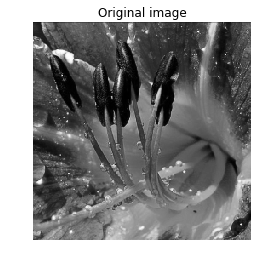

In [9]:
imageplot(f, 'Original image')

In [11]:
f0 = f
f1 = f.flatten()
f1[ argsort(f0.flatten()) ] = np.linspace(0,1,n*n)
#hist(f1.flatten())
I = argsort(f0.flatten())

The algorithm starts at the coarsest scale $ j=\log_2(n)-1 $

In [12]:
j = int(log2(n)-1)

The first step of the algorithm perform filtering/downsampling in the
horizontal direction.

$$ \tilde a_{j-1} = (a_j \star^H h) \downarrow^{2,H}  \quad \text{and} \quad
   \tilde d_{j-1} = (a_j \star^H g) \downarrow^{2,H}$$

Here, the operator $\star^H$ and $\downarrow^{2,H}$
are defined by applying $\star$ and $\downarrow^2$
to each column of the matrix.

The second step computes the filtering/downsampling in the vertical
direction.

$$ a_{j-1}   = (\tilde a_j \star^V h) \downarrow^{2,V}  \quad \text{and} \quad 
   d_{j-1}^V = (\tilde a_j \star^V g) \downarrow^{2,V},$$
$$ d_{j-1}^H = (\tilde d_j \star^V h) \downarrow^{2,V}  \quad \text{and}  \quad
   d_{j-1}^D = (\tilde d_j \star^V g) \downarrow^{2,V}.$$
    
A wavelet transform is
computed by iterating high pass and loss pass filterings with |h| and |g|, followed by sub-samplings.
Since we are in 2-D, we need to compute these filterings+subsamplings
in the horizontal and then in the vertical direction (or
in the reverse order, it does not mind).

Initialize the transformed coefficients as the image itself and set the
initial scale as the maximum one.
fW will be iteratively transformated and will contains the
coefficients.

In [13]:
fW = f.copy()

Select the sub-part of the image to transform.

In [14]:
A = fW[:2**(j+1):,:2**(j+1):]

Apply high and low filtering+subsampling in the vertical direction (1st ooordinate),
to get coarse and details.

In [15]:
Coarse = subsampling(cconv(A,h,1),1)
Detail = subsampling(cconv(A,g,1),1)

Concatenate them in the vertical direction to get the result.

In [16]:
A = concatenate( (Coarse, Detail), axis=0 )

Display the result of the vertical transform.

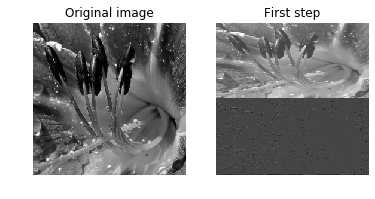

In [17]:
imageplot(f, 'Original image', [1,2,1])
imageplot(A, 'First step', [1,2,2])

Apply high and low filtering+subsampling in the horizontal direction (2nd ooordinate),
to get coarse and details.

In [18]:
Coarse = subsampling(cconv(A,h,2),2)
Detail = subsampling(cconv(A,g,2),2)

Concatenate them in the horizontal direction to get the result.

In [19]:
A = concatenate( (Coarse, Detail), axis=1 )

Assign the transformed data.

In [20]:
fW[:2**(j+1):,:2**(j+1):] = A

Display the result of the horizontal transform.

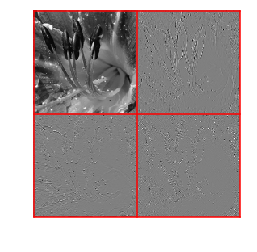

In [21]:
plot_wavelet(fW,j);

Implement a full wavelet transform that extract iteratively wavelet
coefficients, by repeating these steps. Take care of choosing the
correct number of steps.

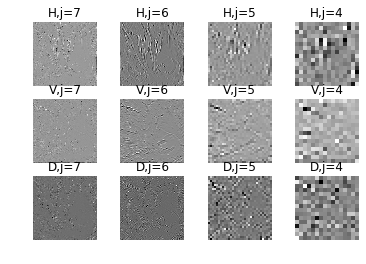

In [26]:
Jmin = 0
Jmax = log2(n)-1
fW = f.copy()
for j in arange(Jmax,Jmin-1,-1):
    A = fW[:int(2**(j+1)):,:int(2**(j+1)):]
    for d in arange(1,3):
        Coarse = subsampling(cconv(A,h,d),d)
        Detail = subsampling(cconv(A,g,d),d)
        A = concatenate( (Coarse, Detail), axis=d-1 )
    fW[:int(2**(j+1)):,:int(2**(j+1)):] = A
    j1 = Jmax-j
    if j1<4:
        subplot(3,4, j1 + 1)
        imageplot(A[:int(2**j):,int(2**j):int(2**(j+1)):], 'H,j=' + str(int(j)) )
        subplot(3,4, j1 + 5)
        imageplot(A[int(2**j):int(2**(j+1)):,:int(2**j):], 'V,j=' + str(int(j)) )
        subplot(3,4, j1 + 9)
        imageplot(A[int(2**j):int(2**(j+1)):,int(2**j):int(2**(j+1)):], 'D,j=' + str(int(j)))

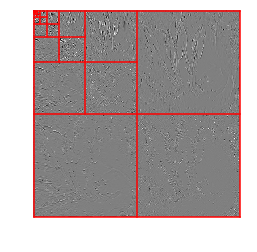

In [27]:
plot_wavelet(fW,Jmin);

### Inverse 2-D Wavelet transform

Inversing the wavelet transform means retrieving a signal `f1` from the
coefficients `fW`. If `fW` are exactely the coefficients of `f`, then
`f=f1` up to machine precision. 

Initialize the image to recover `f1` as the transformed coefficient, and
select the smallest possible scale.

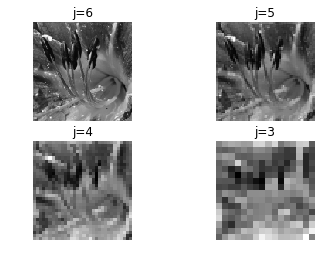

In [34]:
f1 = fW.copy()
for j in arange(Jmin,Jmax+1): 
    j = int(j)
    A = f1[:2**(j+1):,:2**(j+1):]
    for d in arange(1,3):
        if d==1:
            Coarse = A[:2**j:,:]
            Detail = A[2**j:2**(j+1):,:]
        else:
            Coarse = A[:,:2**j:]
            Detail = A[:,2**j:2**(j+1):]
        Coarse = cconv(upsampling(Coarse,d),reverse(h),d)
        Detail = cconv(upsampling(Detail,d),reverse(g),d)
        A = Coarse + Detail
        j1 = Jmax-j
        if j1>0 and j1<5:
            imageplot(A, 'j=' + str(int(j)), [2,2,j1])
    f1[:2**(j+1):,:2**(j+1):] = A

In [36]:
print( 'Error |f-f1|/|f| = ' + str(norm(f-f1)/norm(f)) )

Error |f-f1|/|f| = 8.527742527499094e-12


## Shearlets

Remember that for $f\in L^2(\mathbb{R}^2)$, the (discrete) shearlet transform is given by
$$
\langle f, \psi_{j,k,m}\rangle = \int_{\mathbb{R}^2} f(x)\overline{\psi_{j,k,m}}(x)dx
$$
where
$$
\mathcal{SH}(\psi) = \{\psi_{j,k,m}(x) = 2^{3j/4}\psi(S_kA_jx-m): (j,k)\in \mathbb{Z}^2,m\in\mathbb{Z}^2\}
$$

where,

$$
A_j :=
\left(
\begin{matrix}
2^j & 0 \\
0 & 2^{j/2}
\end{matrix}
\right),
$$
$$
S_k = \left(
\begin{matrix}
1 & k \\
0 & 0
\end{matrix}
\right)
$$


If one has a digital image $f_J = \ell^2(\mathbb{Z}^2)$, that can be obtained from $f$ by
$$
f(x) = \sum_{n\in \mathbb{Z}^2} f_J(n)2^J\psi(2^Jx_1-n_1,2^Jx_2-n_2)
$$
The Digital Shearlet Transform of $f_J$ will be given by

$$
DST^{2D}_{j,k,m}(f_J) = (\overline{\psi_{j,k}^d}\ast f_J)(2^J A_{2^J}^{-1}M_{c_j}m) \quad \text{for}\quad j = 0,...,J-1
$$

where

$$
\psi_{j,k}^d = S_{k/2^{j/2}}(p_j\ast W_j)
$$,

Here $p_j$ is a directional filter in Fourier domain and $W_J$ is the tensor product of a low pass filter and a high pass filter in the Fourier domain.

### Implementation

In [38]:
import numpy as np
from scipy import ndimage as img
from scipy import io as sio
import matplotlib.pyplot as plt
import pyshearlab

Again lets compute the Shearlet transform to the same image. 

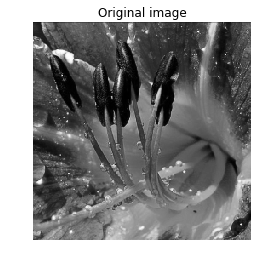

In [42]:
imageplot(f, 'Original image')

#### Computing the shearlet system for 4 scales

In [41]:
scales = 4

In [43]:
shearletSystem = pyshearlab.SLgetShearletSystem2D(0,f.shape[0], f.shape[1], scales)

The shearlet systems is a python dictionary

In [56]:
shearletSystem.keys()

dict_keys(['shearlets', 'size', 'shearLevels', 'full', 'nShearlets', 'shearletIdxs', 'dualFrameWeights', 'RMS', 'useGPU', 'isComplex'])

In [44]:
shearletSystem['shearlets'].shape

(256, 256, 49)

Lets check the first shearlet

In [60]:
shearlet1 = shearletSystem['shearlets'][:,:,0]
print("[Cone, scale, shear] = ",shearletSystem['shearletIdxs'][0])

[Cone, scale, shear] =  [ 1  1 -2]


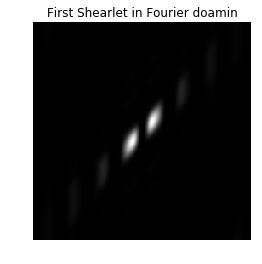

In [61]:
imageplot(shearlet1.real, "First Shearlet in Fourier doamin")

In [48]:
from numpy.fft import fft2, ifft2, ifftshift, fftshift

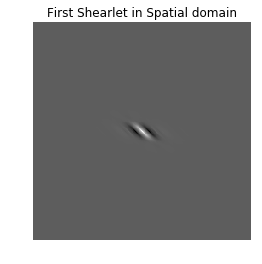

In [74]:
imageplot(fftshift(ifft2(ifftshift(shearlet1))).real, "First Shearlet in Spatial domain")

#### Compute the coefficients

In [64]:
coeffs = pyshearlab.SLsheardec2D(f, shearletSystem)

In [65]:
coeffs.shape

(256, 256, 49)

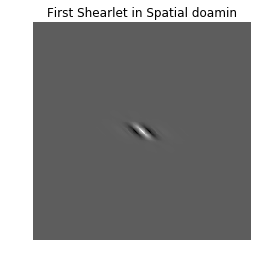

In [75]:
imageplot(fftshift(ifft2(ifftshift(shearletSystem['shearlets'][:,:,0]))).real, "First Shearlet in Spatial doamin")

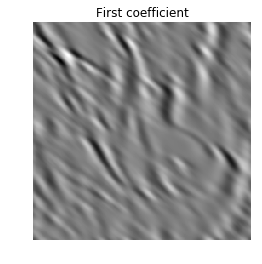

In [77]:
imageplot(coeffs[:,:,0], "First coefficient")

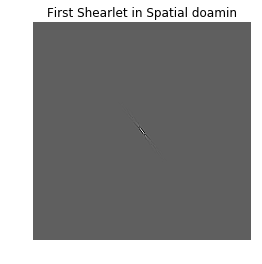

In [80]:
imageplot(fftshift(ifft2(ifftshift(shearletSystem['shearlets'][:,:,20]))).real, "First Shearlet in Spatial doamin")

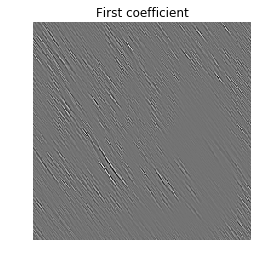

In [81]:
imageplot(coeffs[:,:,20], "First coefficient")

#### Perform the reconstruction

In [82]:
# reconstruction
Xrec = pyshearlab.SLshearrec2D(coeffs, shearletSystem)

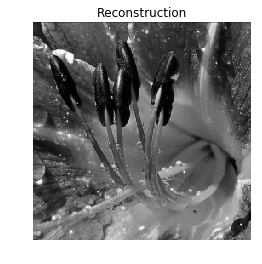

In [83]:
imageplot(Xrec, "Reconstruction")

In [87]:
print( 'Error |f-Xrec|/|f| = ' + str(norm(f-Xrec)/norm(f)) )

Error |f-Xrec|/|f| = 3.0688449254302457e-16


**One can see that the relative error in Shearlet reconstruction using 4 scales is 2 orders of magnitud smaller than the error of the Wavelet reconstruction using 7 scales**